# [실습05] Transfer Learning(2)

## 201810909 컴퓨터과학과 김부용
https://github.com/KBY538/AITrack

### 필요한 파일 가져오기

In [55]:
from os import path
from google.colab import drive

notebooks_dir_name = 'Colab Notebooks'
drive.mount('/content/gdrive')
notebook_base_dir = path.join('./gdrive/My Drive/', notebooks_dir_name)
if not path.exists(notebook_base_dir):
  print('경로를 찾을 수 없음')
  model = torch.load(notebook_base_dir+'/nets/save'+str(n)+'.pkl')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import zipfile
 
# try:
#     with zipfile.ZipFile("animal+utils.zip") as zf:
#         zf.extractall()
#         print("uncompress success")
 
# except:
#     print("uncompress fail")

In [ ]:
# import zipfile

# try:
#     with zipfile.ZipFile("Asia4.zip") as zf:
#         zf.extractall("Asia4/")
#         print("uncompress success")
 
# except:
#     print("uncompress fail")

uncompress success


### 1. Settings
1) Important required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time

In [ ]:
def ComputeCorr(i_data_batch, i_model):  
    correct = 0
    total = 0
    for img, label in i_data_batch:
        torch.no_grad()
        #img = Variable(imgs, volatile=True).cuda()
        img = Variable(img).cuda()  # back prop. 안하고, forward prop. 만 하겠다.
        label = Variable(label).cuda()
        
        output = i_model(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    tmp = 100*correct/total
    tmp = (tmp.cpu()).data.numpy()
    #print("correct: %.2f" %tmp)
    
    return tmp

2) Hyperparameter

In [ ]:
batch_size = 16
learning_rate = 0.0001
epoch = 200

n_node = 1024
dropratio = 0.5

imgsize = 256

### 2. Data Loader
1) 변형 데이터

In [ ]:
# 1. Training data
img_dir = notebook_base_dir+"/Asia4/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2), # CenterCrop(512)
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                             shuffle=True, num_workers=2)

127


2) 고정된 데이터

In [ ]:
# 2. Dev(Val) data
img_dir_dev = notebook_base_dir+"/Asia4/val"
dev_data = dset.ImageFolder(img_dir_dev, transforms.Compose([
    transforms.CenterCrop(imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(dev_data.__len__())

dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                             shuffle=True, num_workers=2)

40


3) 테스트 데이터

In [ ]:
# 3. Test data
img_dir_test = notebook_base_dir+"/Asia4/test"
test_data = dset.ImageFolder(img_dir_test, transforms.Compose([
    transforms.CenterCrop(imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(test_data.__len__())

test_batch = data.DataLoader(test_data, batch_size=batch_size,
                             shuffle=False, num_workers=2)

40


4) 데이터 정보 확인

In [ ]:
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print ("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 4
['china', 'japan', 'korea', 'vietnam']
{'china': 0, 'japan': 1, 'korea': 2, 'vietnam': 3}
127
Training: 127, Dev: 40, Test: 40


### 3. Model
1) Pretrained VGG Model

In [ ]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])
print(list(vgg.children())[0][0])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

2) Customized Fully Model

In [ ]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node), # 현재 n_node 1024
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), # 현재 dropratio 0.5
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass), # 현재 nclass 4
        )
        # weight initializatioin
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data) # ReLU
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

3) Model on GPU

In [ ]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False # 학습시킬 필요 없음
    
for params in model.layer1.parameters():
    params.required_grad = True
    
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### 4. Optimizer & Loss

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

### 5. Train

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 32.28, dev: 10.00, test: 15.00
0...

[0/200] loss: 1.656, 
Correct of train: 25.20, dev: 25.00, test: 10.00, time: 8.70 sec...
Total time: 8.70 sec
1...
Total time: 11.22 sec
2...
Total time: 13.69 sec
3...
Total time: 18.10 sec
4...
Total time: 20.99 sec
5...
Total time: 25.21 sec
6...
Total time: 28.37 sec
7...
Total time: 32.98 sec
8...
Total time: 35.50 sec
9...
Total time: 40.04 sec
10...

[10/200] loss: 1.733, 
Correct of train: 55.12, dev: 47.50, test: 40.00, time: 42.59 sec...
Total time: 42.59 sec
11...
Total time: 46.66 sec
12...
Total time: 49.26 sec
13...
Total time: 53.42 sec
14...
Total time: 56.77 sec
15...
Total time: 61.03 sec
16...
Total time: 64.13 sec
17...
Total time: 67.91 sec
18...
Total time: 71.18 sec
19...
Total time: 75.36 sec
20...

[20/200] loss: 1.129, 
Correct of train: 63.78, dev: 57.50, test: 42.50, time: 78.20 sec...
Total time: 78.20 sec
21...
Total time: 82.12 sec
22...
Total time: 84.75 sec
23

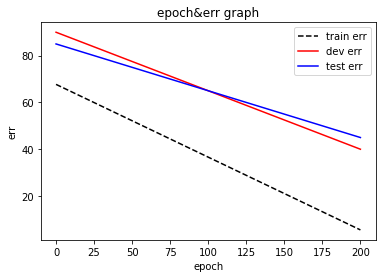

In [ ]:
total_time = 0
disp_step = 10

to_train = True

n = 0
if (to_train==False):
    netname = './nets/racist_vgg19_%d.pkl' % n
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() # evaluation(test) mode
    train_corr = ComputeCorr(train_batch, model)
    dev_corr =ComputeCorr(dev_batch, model)
    test_corr = ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    model.train() # train mode
    
    netname = '/nets/racist_vgg19'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습 이어하기
#     netname = './nets/racist_vgg19_%d' % n
#     model = torch.load(netname)
#     #파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False
#     for params in model.layer1.parameters():
#         params.required_grad = True
#         for i in range(epoch):
    
    for i in range(epoch):
        start_time = time.time()
        print("%d..." %i)
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy()))

            torch.save(model,  notebook_base_dir+netname+'_%d' %n)
            n += 1
            
            model.eval() # evaluation(test) mode
            
            # train, dev, train accr
            train_corr = ComputeCorr(train_batch, model)
            dev_corr = ComputeCorr(dev_batch, model)
            test_corr = ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, time: %.2f sec..." %(train_corr, dev_corr, test_corr, total_time))
            
            model.train() #train mode

        print("Total time: %.2f sec" %total_time)
        
# graph 그리기
x_epoch.append(i+1)
y_train_err.append(100.0-train_corr)
y_dev_err.append(100.0-dev_corr)
y_test_err.append(100.0-test_corr)
plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
plt.plot(x_epoch, y_test_err, color='blue', label='test err')
            
plt.xlabel('epoch')
plt.ylabel('err')
plt.title('epoch&err graph')
plt.legend(loc='upper right')
plt.show()

### 6. Evaluation for dev & test data
1) dev data

In [ ]:
import utils

Normalized confusion matrix


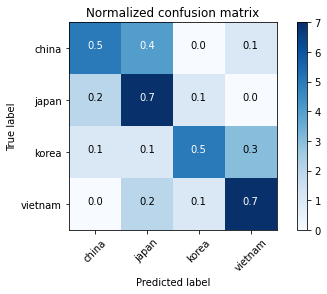

Confusion matrix, without normalization


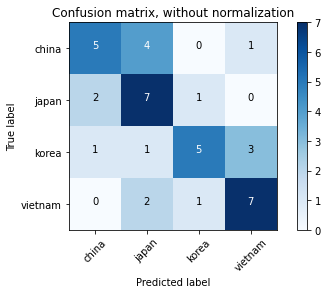

	 acc  |	 pre  |	 rec  |	 f1
 china: 0.80 |	 0.62 |	 0.50 |	 0.56
 japan: 0.70 |	 0.50 |	 0.70 |	 0.58
 korea: 0.75 |	 0.71 |	 0.50 |	 0.59
 vietnam: 0.82 |	 0.64 |	 0.70 |	 0.67
*accuracy: 0.77, precision: 0.62, recall: 0.60, *f1 score: 0.60
[AP]
china: 0.75
japan: 0.65
korea: 0.77
vietnam: 0.83

[mAP] 0.749
[miAP] 0.831


(array([0, 2, 0, 2, 0, 1, 1, 1, 1, 2, 1, 3, 0, 1, 1, 3, 2, 1, 3, 3, 3, 3,
        2, 0, 0, 3, 3, 3, 1, 1, 1, 1, 0, 3, 2, 3, 1, 0, 2, 1]),
 array([1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 3, 0, 0, 1, 0, 2, 0, 3, 2, 3, 3,
        1, 0, 0, 2, 3, 3, 3, 1, 1, 1, 0, 3, 2, 2, 3, 2, 3, 1]),
 array([0.4558391 , 0.57818276, 0.79701596, 0.56224501, 0.99971038,
        0.99646384, 0.54545027, 0.81242758, 0.83223289, 0.89070481,
        0.43453586, 0.98143077, 0.999946  , 0.45225433, 0.51078886,
        0.6564362 , 0.96194243, 0.86396676, 0.99587476, 0.54439253,
        0.9964003 , 0.77105695, 0.54134512, 0.96963096, 0.96116859,
        0.42721343, 0.93203568, 0.95444673, 0.99526608, 0.99361783,
        0.87745792, 0.93811035, 0.98105723, 0.81585354, 0.98932695,
        0.51852447, 0.4602018 , 0.83476043, 0.68222153, 0.6242671 ]))

In [ ]:
model.eval() # evaluation(test) mode
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

2) test data

Normalized confusion matrix


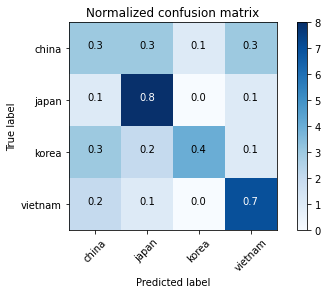

Confusion matrix, without normalization


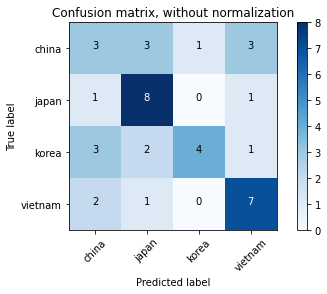

	 acc  |	 pre  |	 rec  |	 f1
 china: 0.68 |	 0.33 |	 0.30 |	 0.32
 japan: 0.57 |	 0.57 |	 0.80 |	 0.67
 korea: 0.65 |	 0.80 |	 0.40 |	 0.53
 vietnam: 0.80 |	 0.58 |	 0.70 |	 0.64
*accuracy: 0.68, precision: 0.57, recall: 0.55, *f1 score: 0.54
[AP]
china: 0.52
japan: 0.81
korea: 0.84
vietnam: 0.63

[mAP] 0.698
[miAP] 0.794


(array([1, 0, 3, 1, 1, 0, 3, 0, 2, 3, 3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        2, 0, 3, 1, 1, 2, 2, 2, 0, 3, 0, 3, 1, 3, 3, 3, 3, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([0.49267805, 0.99369109, 0.62986398, 0.92095518, 0.38527915,
        0.99993759, 0.80157542, 0.60815287, 0.79496175, 0.92862016,
        0.99553972, 0.71436745, 0.9717778 , 0.98767871, 0.69004107,
        0.99311817, 0.68455958, 0.99504465, 0.80521375, 0.9995268 ,
        0.4993169 , 0.53861851, 0.97130686, 0.6494177 , 0.78200942,
        0.60688484, 0.44219905, 0.99922639, 0.99802274, 0.99669302,
        0.84865361, 0.91216838, 0.47050041, 0.99631268, 0.79313213,
        0.76983774, 0.71116805, 0.44357842, 0.99389541, 0.99420583]))

In [ ]:
model.eval() # evaluation(test) mode
utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: china
 True predicted images/total china category: 5 / 10
Predicted probability:
[9.6116859e-01 8.8228309e-04 9.3354834e-03 2.8613659e-02]


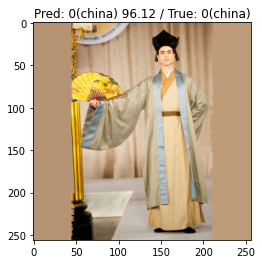

 False predicted images/total china category: 5 / 10
Predicted probability:
[0.01101953 0.86396676 0.11365888 0.01135482]


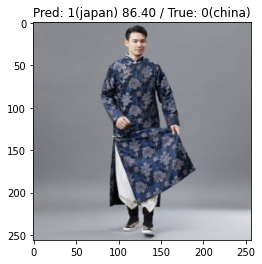

Category: japan
 True predicted images/total japan category: 7 / 10
Predicted probability:
[1.8553870e-02 9.3811035e-01 4.3268718e-02 6.7073219e-05]


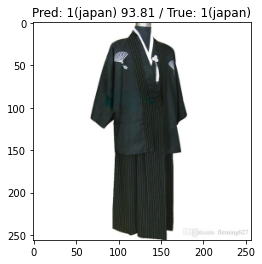

 False predicted images/total japan category: 3 / 10
Predicted probability:
[0.0157979  0.17638074 0.5413451  0.2664762 ]


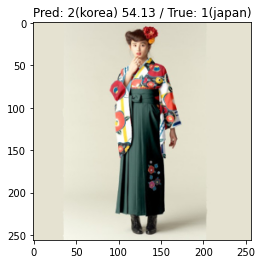

Category: korea
 True predicted images/total korea category: 5 / 10
Predicted probability:
[0.00738264 0.39768374 0.57818276 0.01675085]


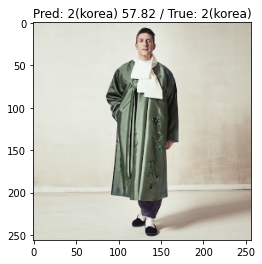

 False predicted images/total korea category: 5 / 10
Predicted probability:
[0.8347603  0.00145357 0.16027342 0.0035127 ]


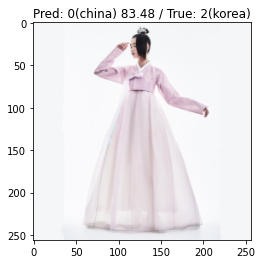

Category: vietnam
 True predicted images/total vietnam category: 7 / 10
Predicted probability:
[0.05898133 0.00427559 0.00470741 0.9320357 ]


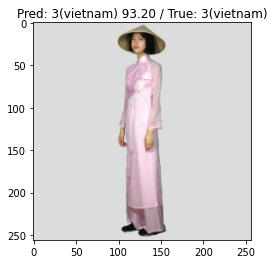

 False predicted images/total vietnam category: 3 / 10
Predicted probability:
[0.07362664 0.46020257 0.29314888 0.17302188]


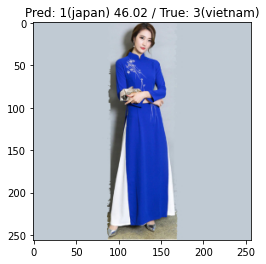

In [56]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=1)